# I.Milestone: Data Discovery and preprocessing steps

#TODO bevezető szöveg, nagy chart a dataflowról

## Installs and import

In [37]:
!pip install -r requirements.txt

In [38]:
import pandas as pd
import os
from typing import List

from Participant import Participant
from NWBData import NWBData
from PreProcessedData import PreProcessedData
import glob
import zipfile
import requests
import io
import numpy as np
import wavfile

#from create_dataloaders import create_dataloaders

## 1. Original dataset

#TODO: írni az eredeti dataszetről 

In [16]:
#downloading zip file
r = requests.get("https://osf.io/download/g6q5m")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("./")

### Loading participant info

In [13]:
DEFAULT_PATH_BIDS = r'./SingleWordProductionDutch-iBIDS'
DEFAULT_FEATURES_PATH = r'./features'
pd_participants = pd.read_csv(os.path.join(DEFAULT_PATH_BIDS,'participants.tsv'), delimiter='\t')

In [14]:
participants = [Participant(pd_participants.iloc[p_idx],p_idx) for p_idx in range(pd_participants.shape[0])]

In [15]:
p_ids = [p.get_model().participant_id for p in participants]

In [16]:
print(p_ids)

['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10']


In [17]:
for p in participants:
    print(p.get_model())

p_idx=0 participant_id='sub-01' age=20 sex=<SexEnum.FEMALE: 'Female'> hand=nan
p_idx=1 participant_id='sub-02' age=43 sex=<SexEnum.MALE: 'Male'> hand=nan
p_idx=2 participant_id='sub-03' age=24 sex=<SexEnum.MALE: 'Male'> hand=nan
p_idx=3 participant_id='sub-04' age=46 sex=<SexEnum.FEMALE: 'Female'> hand=nan
p_idx=4 participant_id='sub-05' age=50 sex=<SexEnum.FEMALE: 'Female'> hand=nan
p_idx=5 participant_id='sub-06' age=16 sex=<SexEnum.MALE: 'Male'> hand=nan
p_idx=6 participant_id='sub-07' age=47 sex=<SexEnum.MALE: 'Male'> hand=nan
p_idx=7 participant_id='sub-08' age=22 sex=<SexEnum.FEMALE: 'Female'> hand=nan
p_idx=8 participant_id='sub-09' age=20 sex=<SexEnum.FEMALE: 'Female'> hand=nan
p_idx=9 participant_id='sub-10' age=36 sex=<SexEnum.MALE: 'Male'> hand=nan


#TODO: szöveg mi állapítható meg a résztvevőkről?

### Loading NWBData

In [23]:
nwb_datas: List[NWBData] = []

for participant in participants:
    participant_id = participant.get_model().participant_id
    nwb_datas.append(NWBData(participant_id,path_bids=DEFAULT_PATH_BIDS))

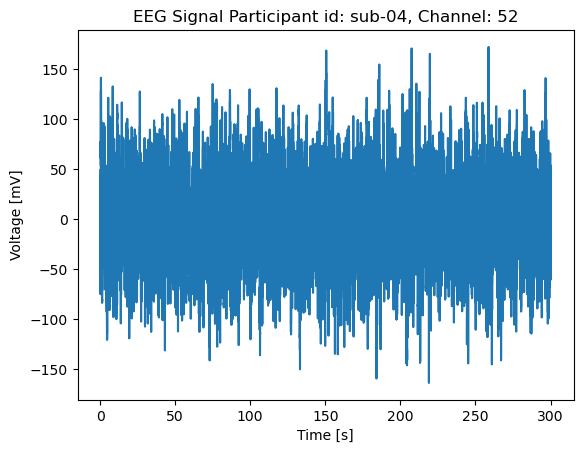

In [19]:
nwb_datas[3].display_eeg_signal(52)

## 2. Extracting features

#TODO: ábra a feature_extraction data_flow-járól

In [20]:
!python SingleWordProductionDutch/extract_features.py

^C


#### Hilbert transform demo
from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, chirp

def hilbert_demo():
    duration = 1.0
    fs = 400.0
    samples = int(fs*duration)
    t = np.arange(samples) / fs
    
    signal = chirp(t, 20.0, t[-1], 100.0)
    signal *= (1.0 + 0.5 * np.sin(2.0*np.pi*3.0*t) )
    
    analytic_signal = hilbert(signal)
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = (np.diff(instantaneous_phase) /
                               (2.0*np.pi) * fs)
    
    fig, (ax0, ax1) = plt.subplots(nrows=2)
    ax0.plot(t, signal, label='signal')
    ax0.plot(t, amplitude_envelope, label='envelope')
    ax0.set_xlabel("time in seconds")
    ax0.legend()
    ax1.plot(t[1:], instantaneous_frequency)
    ax1.set_xlabel("time in seconds")
    ax1.set_ylim(0.0, 120.0)
    fig.tight_layout()

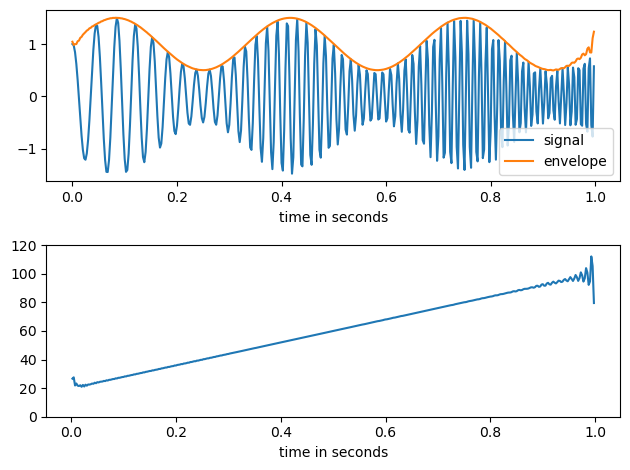

In [12]:
hilbert_demo()

### 3. Visualizing preprocessed data

In [24]:
preprocessed_ds = []
for p_id in p_ids:
    preprocessed_ds.append(PreProcessedData(p_id,DEFAULT_FEATURES_PATH))

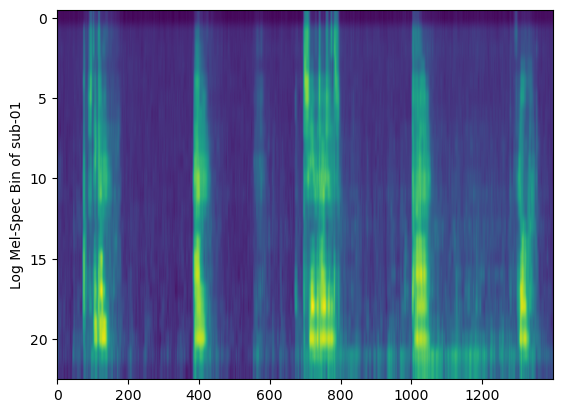

In [25]:
preprocessed_ds[0].display_spectogram()

In [24]:
for pre_ds in preprocessed_ds:
    model = pre_ds.get_model()
    print(f"Participant: {model.p_id}")
    print(f"Feature shape: {model.features.shape}")
    print(f"Spectogram shape: {model.spectogram.shape}")
    print()

Participant: sub-01
Feature shape: (29985, 1143)
Spectogram shape: (29985, 23)

Participant: sub-02
Feature shape: (29985, 1143)
Spectogram shape: (29985, 23)

Participant: sub-03
Feature shape: (29986, 1143)
Spectogram shape: (29986, 23)

Participant: sub-04
Feature shape: (29986, 1035)
Spectogram shape: (29986, 23)

Participant: sub-05
Feature shape: (29984, 540)
Spectogram shape: (29984, 23)

Participant: sub-06
Feature shape: (29993, 1143)
Spectogram shape: (29993, 23)

Participant: sub-07
Feature shape: (29991, 1143)
Spectogram shape: (29991, 23)

Participant: sub-08
Feature shape: (29992, 486)
Spectogram shape: (29992, 23)

Participant: sub-09
Feature shape: (29993, 1053)
Spectogram shape: (29993, 23)

Participant: sub-10
Feature shape: (28460, 1098)
Spectogram shape: (28460, 23)



Dimensions doesn't match!

## 4. Creating DataLoaders

In [4]:
from create_dataloaders import main
train_dl,val_dl,test_dl = main()

## 5. Reconstruct Wav file from spectrogram

The following code snippet is from SingleWordProductionDutch. Using this the spectrogram can be converted into a numpy.ndarray representation of a wavfile.

In [45]:
import SingleWordProductionDutch.reconstructWave as rW
import SingleWordProductionDutch.MelFilterBank as mel

def createAudio(spectrogram, audiosr=16000, winLength=0.05, frameshift=0.01):
    """
    Create a reconstructed audio wavefrom
    
    Parameters
    ----------
    spectrogram: array
        Spectrogram of the audio
    sr: int
        Sampling rate of the audio
    windowLength: float
        Length of window (in seconds) in which spectrogram was calculated
    frameshift: float
        Shift (in seconds) after which next window was extracted
    Returns
    ----------
    scaled: array
        Scaled audio waveform
    """
    mfb = mel.MelFilterBank(int((audiosr*winLength)/2+1), spectrogram.shape[1], audiosr)
    nfolds = 10
    hop = int(spectrogram.shape[0]/nfolds)
    rec_audio = np.array([])
    for_reconstruction = mfb.fromLogMels(spectrogram)
    for w in range(0,spectrogram.shape[0],hop):
        spec = for_reconstruction[w:min(w+hop,for_reconstruction.shape[0]),:]
        rec = rW.reconstructWavFromSpectrogram(spec,spec.shape[0]*spec.shape[1],fftsize=int(audiosr*winLength),overlap=int(winLength/frameshift))
        rec_audio = np.append(rec_audio,rec)
    scaled = np.int16(rec_audio/np.max(np.abs(rec_audio)) * 32767)
    return scaled